In [1]:
# import necessary libraries
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
# create sparksession
spark = SparkSession \
.builder \
.appName("Pysparkexample") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()


In [2]:
 #Read data without specifying a delimiter
file_location = "disney_movies_total_gross.csv"
file_type = "csv"
infer_schema = "false"
first_row_is_header = "true"

df = spark.read.format(file_type)\
    .option("inferSchema", infer_schema)\
    .option("header", first_row_is_header)\
    .load(file_location)

In [3]:
# Show the Data Schema
df.printSchema()


root
 |-- movie_title: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- mpaa_rating: string (nullable = true)
 |-- total_gross: string (nullable = true)
 |-- inflation_adjusted_gross: string (nullable = true)



In [4]:
# Casting
df = df.withColumn('total_gross',df['total_gross'].cast("float"))
df = df.withColumn('inflation_adjusted_gross',df['inflation_adjusted_gross'].cast("float"))

df.printSchema()

root
 |-- movie_title: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- mpaa_rating: string (nullable = true)
 |-- total_gross: float (nullable = true)
 |-- inflation_adjusted_gross: float (nullable = true)



<Axes: xlabel='total_gross', ylabel='movie_title'>

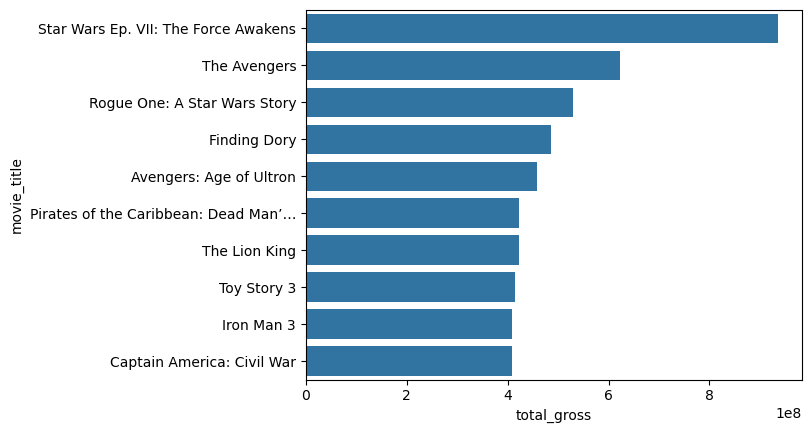

In [5]:
df.createOrReplaceTempView('MovieData')
plot_df = spark.sql(
"""
SELECT movie_title, total_gross FROM MovieData
ORDER BY total_gross DESC
LIMIT 10
"""
).toPandas()
import seaborn as sns
sns.barplot(plot_df, y='movie_title', x='total_gross')

In [6]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder \
.appName("Linear Regression with PySpark MLlib") \
.getOrCreate()

In [8]:
assembler = VectorAssembler(
inputCols=["total_gross"],
outputCol="features")

data = assembler.transform(df)
final_data = data.select("features", "inflation_adjusted_gross")

train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)


In [9]:
lr = LinearRegression(featuresCol="features", labelCol="inflation_adjusted_gross", predictionCol="predicted_inflation_adjusted_gross")


In [10]:
lr_model = lr.fit(train_data)

In [11]:
pred_results = lr_model.evaluate(test_data)

pred_results.predictions.show()

+-------------+------------------------+----------------------------------+
|     features|inflation_adjusted_gross|predicted_inflation_adjusted_gross|
+-------------+------------------------+----------------------------------+
|        [0.0]|                     0.0|              3.2346491818131298E7|
|    [34368.0]|                 65543.0|              3.2391779151509527E7|
|    [48658.0]|                 51988.0|               3.241060934220945E7|
|   [226792.0]|                337782.0|              3.2645339726403978E7|
|   [468240.0]|                907414.0|              3.2963500110176872E7|
|   [784419.0]|               1409943.0|              3.3380134880317565E7|
|  [1391434.0]|               1563976.0|               3.418000949247382E7|
|  [2461628.0]|               4770461.0|              3.5590223425707676E7|
|  [3404935.0]|               7035189.0|               3.683323607081411E7|
|  [3469493.0]|               7168577.0|              3.6918305311626256E7|
|  [3523909.